# <span style="color:orange">3:</span>  What affects risk of fatal attacks for individuals

*Here "2. Basic stats" and "3. Data analysis" will be described for part 3 of the analysis. The descriptions will be done fluenty as described below.*


This part analyses social data of COVID-19 patients in South Korea.

The goal is to construct a machine learning model for predicting risk of dying from COVID-19, interpret the results and construct a widget that citizens of South Korea can use to get a personal risk-profile with recommendations. 

The analysis is divided into seven parts:

1. **Investigation:** Where the data is investigated descriptively
1. **Preparation:** Where the data is prepared for machine learning
2. **Modelling:** Where the model is being trained and evaluated
3. **Interpretation:** Where the model is being interpreted
4. **Beautify & Widgetting:** Where the personalized risk-profiling widget is being constructed and pretty and interactive graphs made based on previous data
1. **Conclusion and discussion:** As title suggests
1. **References:** As title suggests

## <span style="color:orange">1:</span> Investigation 

Import all packages needed.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import eli5
from eli5 import show_prediction
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import plotly
from plotly import graph_objs as go, offline as po, tools
import numpy as np
import json
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HTML
import plotly.graph_objs as go
from ipywidgets import interact
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix
from IPython.display import Image

The dataset used is the PatientInfo dataset. The dataset holds various information related to each COVID-19 patient registered.

In [6]:
## Load data
path = "data/PatientInfo.csv"
df = pd.read_csv(path)
df.head(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [7]:
print("Basic stats of the dataset\n")
print("Number of patients: ", df['patient_id'].count())
print("Attributes pr. patient: ", len(df.columns))

Basic stats of the dataset

Number of patients:  3388
Attributes pr. patient:  18


To get an idea of the contents of the dataset, some basic graphs will be presented below; Showing distributions of a select number of attributes of the data. The graphs shows:

1. Distribution of gender
1. Distribution of age
1. Distribution of provinces
1. Distribution of type of infection cases
1. Distribution of other infections simultanious with COVID-19 (disease column)
1. Distribution of released, isolated and deceased patients

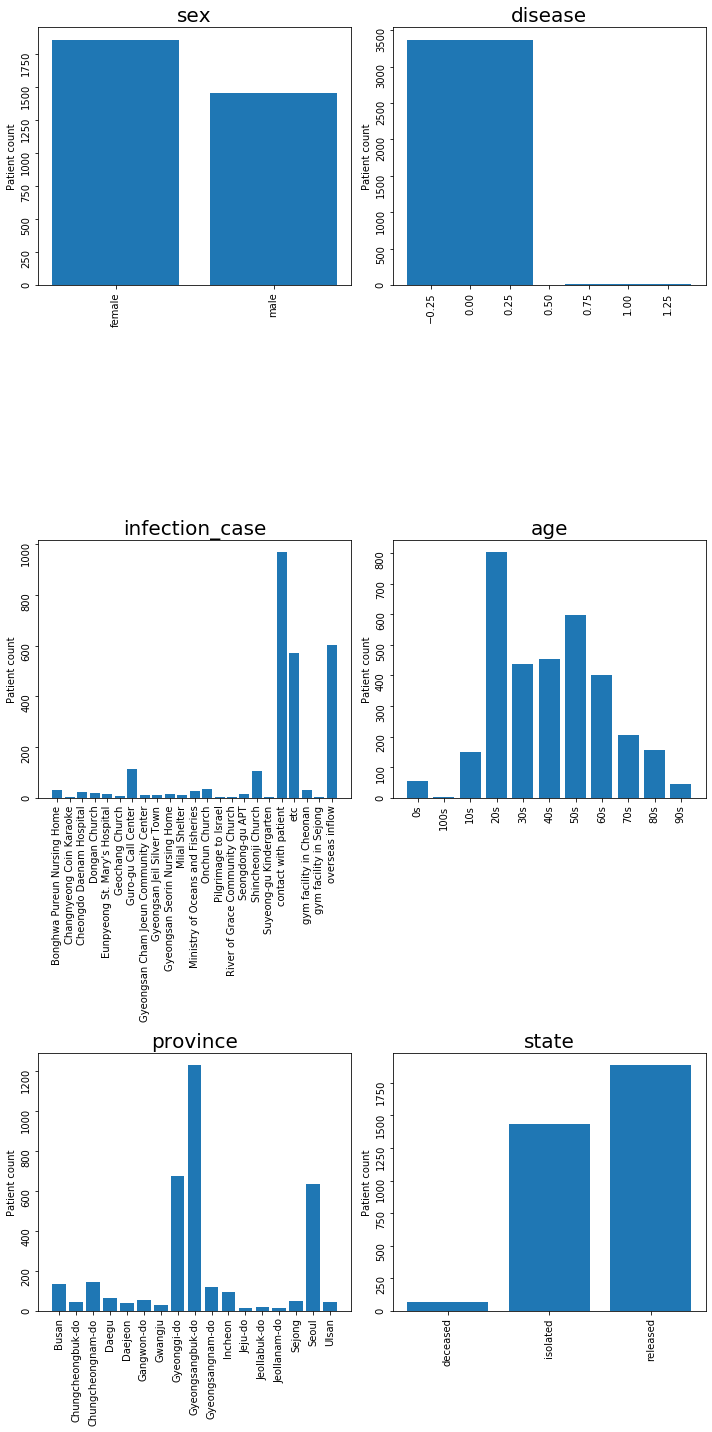

In [8]:
# Get columns of relevance
df_dists = df.drop(columns = ['patient_id', 'global_num', 'birth_year', 'country', 'city', 'infection_order', 'infected_by', 'contact_number', 'symptom_onset_date', 'released_date', 'confirmed_date', 'deceased_date'])
df_dists['disease'].fillna(0, inplace = True)

# Define indices
I, J = 2*[0, 1, 2], 3*[0, 1]

# Construct plots
fig, axs = plt.subplots(3, 2, figsize = [10, 20])

for column, i, j in zip(df_dists.columns, I, J):
    y = df_dists.groupby(column)[column].count().to_numpy()
    x = df_dists.groupby(column)[column].count().index.to_numpy()
    axs[i,j].bar(x, y)
    axs[i,j].set_title(column, fontsize=20)
    axs[i,j].set_ylabel('Patient count', rotation = 90)
    axs[i,j].tick_params(labelrotation=90)
    
fig.tight_layout()
plt.show()   

A couple of things can be noted from each graph. Below are some important notes for each distribution:

1. **Sex:** There exists a small majority of females in the dataset. 
2. **Disease:** Most patients do not have an existing disease, only very few have. 
3. **Infeciton case:** Most cases come from "contact with patient", "etc" or "overseas inflow"
4. **age:** There seems to be most people in their 20s, but except for that a normal distribution with most people in their 50s
5. **Province:** Most people come from three major provinces, "Seoul", "Gyenggi-do" and "Gyeongsangbuk-do".
6. **State:** Most people are currently "isolated" however, in prediction only "deceased" and "released" are relevant why a big part of the data will not be able to be used in the modelling. 

In conclusion, it is easy to see that this data is still in its infantry and more information would be helpful. However, for a basic model there does seem to be enough patients and feature to create a proof of concept model, and hopefully learn something about the features as well.

## <span style="color:orange">2:</span> Prepare data

The data must be prepared such that it is fit for the machine-learning task. In the block below, the following things have been done. 

1. **Drop data:** Features (columns) of the dataframe that cannot help the model with predictions are removed. For instance "infected by" should not have an impact on the risk of death as the virus is the same no matter who you were infected by. 
1. **Feature construction:** Some features may not be interesting in itself (such as the date of virus contraction) however, the day of contraction compared to the first case in the country may, as early cases could be hypothesised to have less treatments available, and later cases more. As such, this new feature is created based on existing information. 
1. **Feature formatting:** In this project scikit-learn has been used as the machine learning foundation. However, as the package does not work well with categorical variables, all of these (sex, disease and province column) are OneHotEncoded. Additionally, columns are formattet to be strictly integers instead of mixed types (for instance, age represented by "50" instead of "50s") as the model will not be able to interpret the features otherwise. 
1. **Data removal:** As a lot of the dataset refers to "isolated" people which is not a good classification label. As such, this portion of the dataset must be removed to make room for a binary classification (released vs. diseased).
1. **Misc:** Renaming etc.

In [9]:
# Reduce data 
df.drop(columns=['patient_id','infection_case', 'symptom_onset_date', 'global_num', 'birth_year', 'country', 'city', 'infection_order', 'infected_by', 'contact_number', 'released_date', 'deceased_date'], inplace = True)

# New column "Days since first case"
df['confirmed_date'] = pd.to_datetime(df['confirmed_date'], errors='coerce')
firstCase = df['confirmed_date'].min()
df['Days since first case'] = df['confirmed_date'] - firstCase
df.drop(columns = ['confirmed_date'], inplace = True)

# Binarising 
df = df[df['sex'].notna()]
gender = {'male': 0,'female': 1} 
df.sex = [gender[item] for item in df.sex]

# OneHotEncoding
df = pd.get_dummies(df, columns=["disease"], prefix='', prefix_sep='')
df = pd.get_dummies(df, columns=["province"], prefix='', prefix_sep='')

# Clean age
df['age'] = df['age'].str.replace(r's$', '')
df = df[df['age'].notna()]
df = df.astype({"age": int})

# Convert timedeltas to integer
df['Days since first case'] = df['Days since first case'].dt.days

# Remove "Isolated state"
df = df[df['state'] != 'isolated']

# Rename a column
df = df.rename(columns={'True': 'Existing illness'})

df.head(5)

,sex,age,state,Days since first case,Existing illness,Busan,Chungcheongbuk-do,Chungcheongnam-do,Daegu,Daejeon,...,Gyeonggi-do,Gyeongsangbuk-do,Gyeongsangnam-do,Incheon,Jeju-do,Jeollabuk-do,Jeollanam-do,Sejong,Seoul,Ulsan
0,0,50,released,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,30,released,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,50,released,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,20,released,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,20,released,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


A quick investigation of the dataframe to see if NaN's are present show that the dataset is complete and ready for modelling using 'Missingno' [1]. 

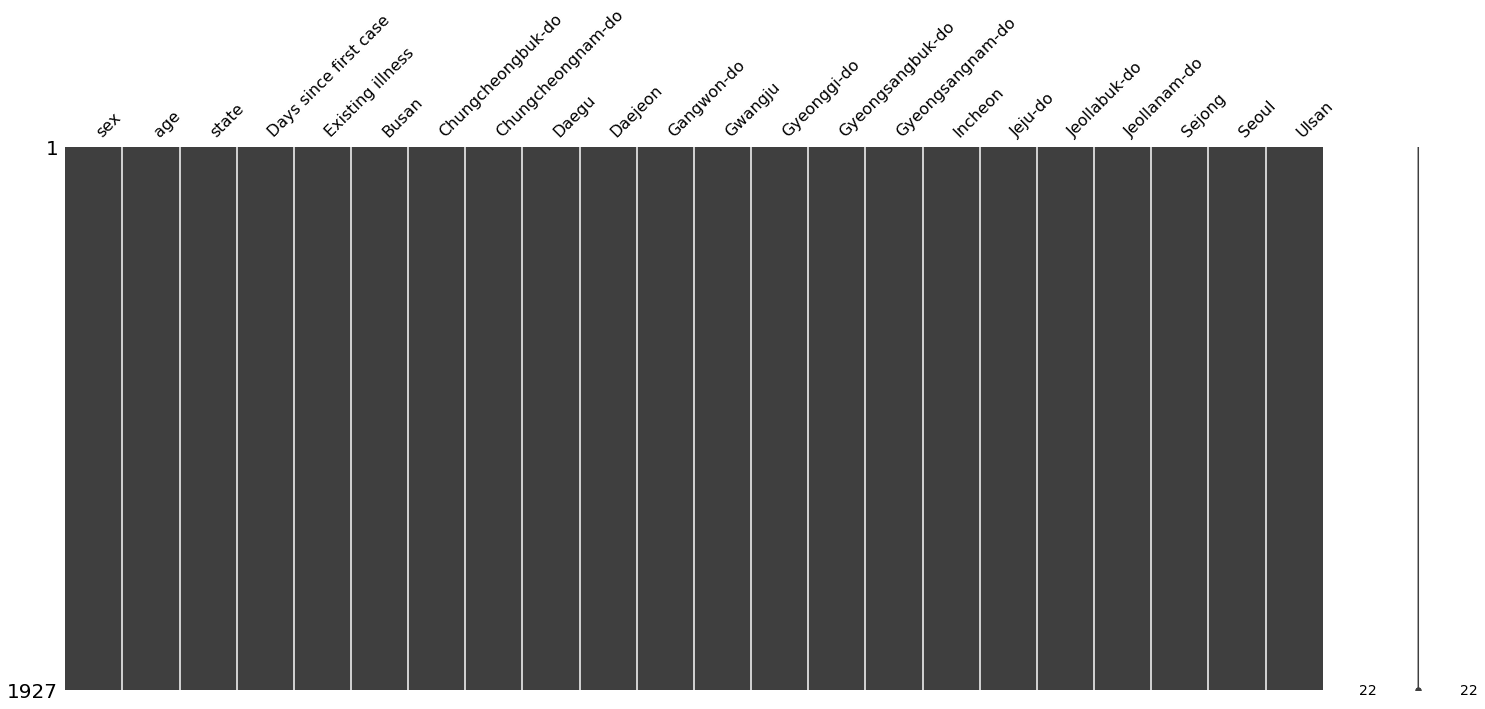

In [10]:
msno.matrix(df) # Nans will show up as empty space and indicated on the y-axis to the right if any exists

## <span style="color:orange">3:</span> Modelling 

In order to create the most robust and trustworthy model, the following steps will be executed:

1. Create naive baseline model
1. Create initial random forest classifier
1. Feature selection 
1. Hyperparameter tuning 
1. Final model evaluation 

The same training and test dataset will be used for all models. The sklearning library will be used throughout this section [4].

In [11]:
# Split into test and training data
X = df.drop(columns = ['state'])
y = df[['state']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, shuffle=True, random_state=5)

Additionally, as evaluation criteria it is important to note that 'accuracy' is a poor performance criteria as the dataset is extremely unbalanced as can be seen below.

In [12]:
df.groupby('state')['state'].count()

state
deceased      69
released    1858
Name: state, dtype: int64

For imbalanced datasets, measures such as F-measure or AOC usually provide are better evaluation, however, these will still put a lot of weight on predicting who will survive as can be read in [2] [3]. However, considering the problem at hand, it will be much worse to classify a high-risk person as low-risk, than it will to classify a low-risk person as high-risk. As such, 'Recall' will be used as an evaluation criteria. Recall aims at improving how good the model is at finding positive samples, which in this instance is people that are predicted to die from COVID-19. 

### <span style="color:orange">3.1:</span> Naive baseline model  

Recall:  [0. 1.]


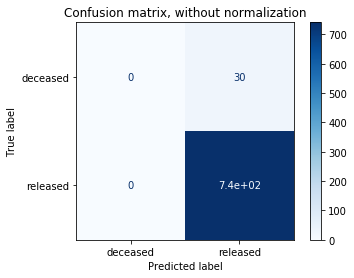

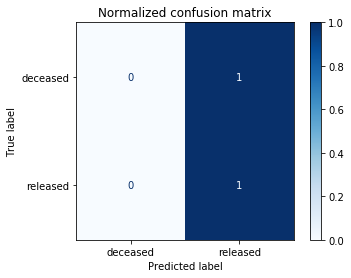

In [13]:
# Train classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Predict
y_pred = dummy_clf.predict(X_test)
yhat = dummy_clf.predict_proba(X_test)
y_prob = yhat[:, 1]

# Evaluate
eval_F1 = metrics.f1_score(y_test, y_pred, average=None)
eval_AUC = metrics.roc_auc_score(y_test, y_prob)
eval_Recall = metrics.recall_score(y_test, y_pred, average=None)

# Print results
print("Recall: ", eval_Recall)
#print("AUC: ", eval_AUC)
#print("\nF1-score\n", "deceased: ", eval_F1[0], "\n", "released: ", eval_F1[1])

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dummy_clf, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

Here it can be seen that the recall evaluates the model as useless, as it did not find a single positive person. 

By calculating the accuracy of the model it becomes apparent why this is not a good measure for the dataset.

In [14]:
print("Accuracy for the dummy classifier is: ", metrics.accuracy_score(y_test, y_pred))

Accuracy for the dummy classifier is:  0.9610894941634242


Not a very good evaluation criteria!

### <span style="color:orange">3.2:</span> Initial Random Forest Classification

The initial model will be a simple model with best-guess parameters without any tuning. 

Recall:  [0.33333333 1.        ]


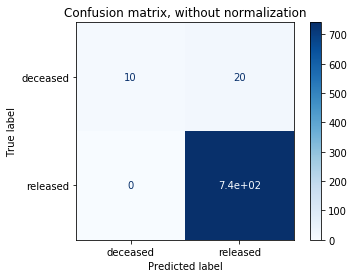

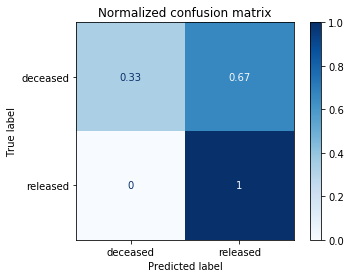

In [15]:
# Build model
clf = RandomForestClassifier(max_depth=5, random_state=5)
clf = clf.fit(X_train,y_train.values.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_test)
yhat = clf.predict_proba(X_test)
y_prob = yhat[:, 1]

# Evaluate
eval_Recall = metrics.recall_score(y_test, y_pred, average=None)
print("Recall: ", eval_Recall)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

The model certainly performs better than the baseline, however, many of the deceased are still being misclassified as released and only 33% of deceased are being classified correctly.

### <span style="color:orange">3.3:</span> Feature selection

Although feature selection and hyperparameter tuning optimally is done simultaniously, [5] suggests performing feature selection after initial model construction and tuning hyperparameters after for simplicity. 

The features of the dataset will be investigated from three different angles:
1. **Chi-squared testing:** Sklearn's Kbest
1. **Feature importance:** From RFC
1. **Pearson correlations:** Heatmap investigation



#### <span style="color:orange">3.3.1:</span> Kbest

Kbest is a univariate feature selection that selects the best feature based on some univariate statistical test. Here the Chi-squared has been chosen. The statistical test essentially returns a p-value based on how important the feature is. 

In [16]:
# Extract top 15 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Print scores
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(15,'Score'))  

                  Feature        Score
1                     age  1794.304616
3        Existing illness   484.695652
7                   Daegu   442.150362
19                  Seoul    11.688245
0                     sex     4.819397
6       Chungcheongnam-do     4.716362
12       Gyeongsangbuk-do     4.224252
13       Gyeongsangnam-do     3.565124
14                Incheon     2.042519
2   Days since first case     1.960635
18                 Sejong     1.485468
5       Chungcheongbuk-do     1.448332
8                 Daejeon     1.262648
10                Gwangju     0.779871
9              Gangwon-do     0.740068


'Age' and 'Existing illness' seems to be best predicters. However, Daegu seems to attract a score almost as high as 'Existing illness' which seems odd. 

#### <span style="color:orange">3.3.2:</span> Feature importance

When the random forest classifier decides which splits to make in each tree it is based on some impurity measure. The weighted averages of each impurity measure can be used as a feature evaluation criteria for the classifier with each value essentially describing how good the feature is at making pure splits in the tree.

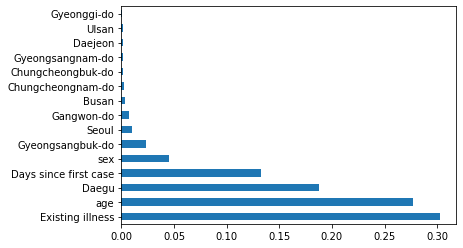

In [17]:
feature_importance = pd.Series(clf.feature_importances_, index=X.columns)
feature_importance.nlargest(15).plot(kind='barh')
plt.show()

The initial model seems to weigh existing illness highest, and Daegu as the second highest! Daegu seems to be the place not to be during COVID-19! ... Unless there could be some error in the data? 

#### <span style="color:orange">3.3.3:</span> Pearson correlations

The pearson correlation simply looks at how features are correlated, and albeit being a simple measure it can show tremendous amounts of insides in the dataset.

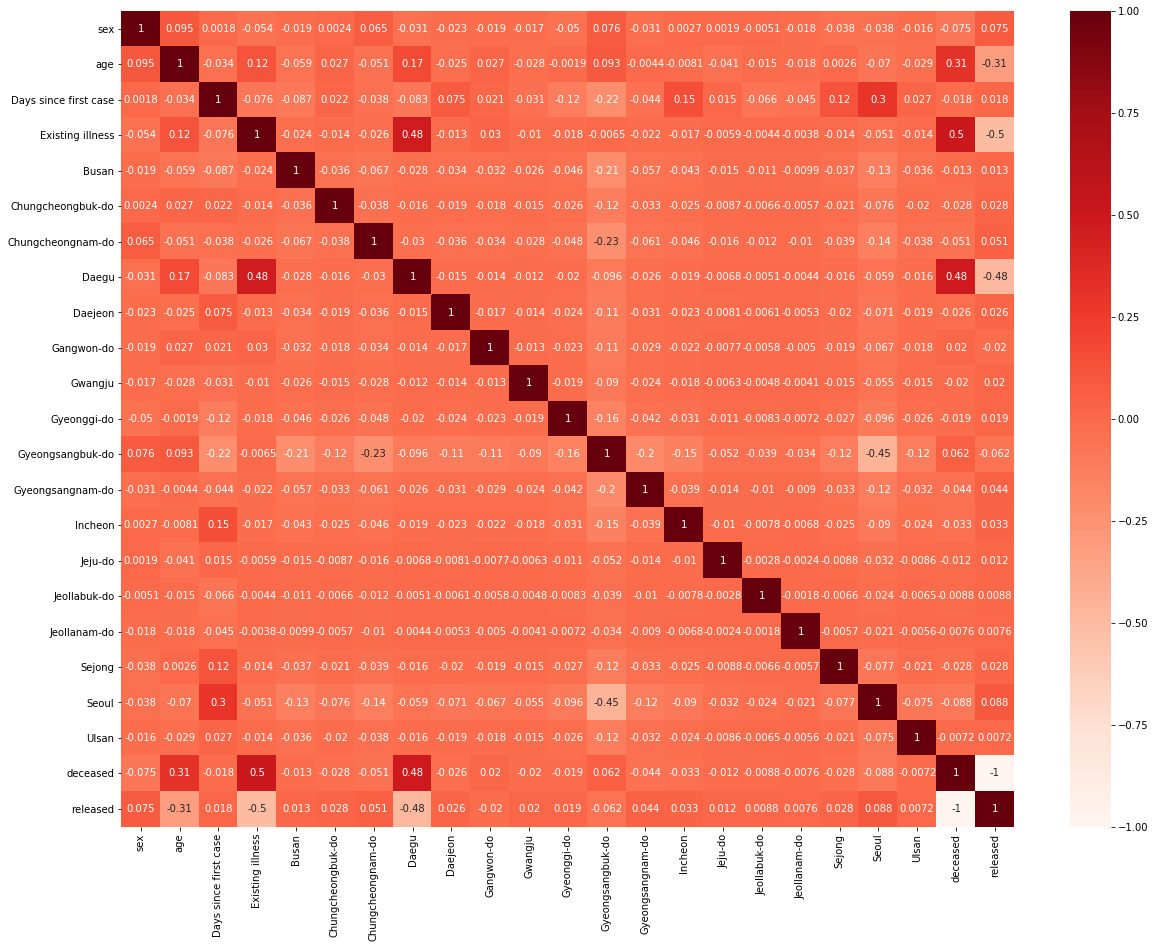

In [18]:
df_corr = pd.get_dummies(df, columns=["state"], prefix='', prefix_sep='')
plt.figure(figsize=(20,15))
cor = df_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Here it can be seen that "Age", "Existing illness" and "Daegu" have the highest correlation with the labels "Deceased"/"Released". However, "Daegu" also have a very high correlation with "Existing illness" which might hint as to where the issue lies! After a quick analysis it can indeed be seen that the PatientInfo dataset has an issue with 'Daegu'. This can be seen from the fact that the other datasets contain significantly more information on 'Daegu' than the PatientInfo dataset why it seems some data has been lost. The data that has been left for 'Daegu' primarily consists of patients with Existing illness therefor heavily biasing the data towards this region. 

**In conclusion:** Daegu will be removed from the features due to quality issues and a heavy bias. The rest of the regions will be kept. Although they individually shows low importance as a sum they might improve the model. The feature removal will undoubtly remove some accuracy but it will make the results more reliable.

In [19]:
# Split into test and training data
X = df.drop(columns = ['state', 'Daegu'])
y = df[['state']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, shuffle=True, random_state=5)

### <span style="color:orange">3.4:</span> Hyperparameter tuning

The hyperparameter tuning of the model will be done using Grid Search Crossvalidation.
Grid search cross validation selects an interval of the different parameters and completely exhausts combinations to find the optimal hyperparameters [6].

In [20]:
# Setup parameters for tuning #20, 2, 20
parameters = {
    'max_depth': [2, 3, 5, 6, 8, 10, 20],
    'max_features': [2, 3, 5, 10, 21],
    'n_estimators': [5, 7, 10, 15, 20, 50, 100, 200]
}

In [21]:
# Construct 5-fold crossvalidation
#CV = KFold(5,shuffle=True,random_state=5).split(X_train)

# Setup evaluation and gridsearch
#recall_scorer = make_scorer(recall_score, pos_label="deceased")
#rfc = GridSearchCV(RandomForestClassifier(random_state = 5), parameters,n_jobs=-1,scoring=recall_scorer,cv=CV)

# Fit model
#rfc.fit(X_train,y_train.values.ravel())

# Print best parameters
#print('Best parameters:',rfc.best_params_)

# Evaluate results
#y_pred = rfc.predict(X_test)
#yhat = rfc.predict_proba(X_test)
#y_prob = yhat[:, 1]

# Print Recall
#eval_Recall = metrics.recall_score(y_test, y_pred, average=None)
#print("Recall: ", eval_Recall)

In [22]:
# Train model with tuned parameters
rfc = RandomForestClassifier(max_depth=20, max_features=2, n_estimators=20, random_state=5)
rfc = rfc.fit(X_train,y_train.values.ravel())

# Evaluate results
y_pred = rfc.predict(X_test)
yhat = rfc.predict_proba(X_test)
y_prob = yhat[:, 1]

# Print Recall
eval_Recall = metrics.recall_score(y_test, y_pred, average=None)
print("Recall: ", eval_Recall)

Recall:  [0.4        0.98920378]


Comparing to the baseline, the model slightly improves correct classifications for unseen data.

### <span style="color:orange">3.5:</span> Final evaluation

Tuning various parameters found that the best model predicts 40% of deceased correct for unseen data, slightly outperforming  the simple model as was seen above, and significantly outperforming the naive model. Performance on unseen data can be seen below.

Altough the predictions seem bad, the model still predicts 70% correct for the whole dataset, and even correctly picking out 10 people from a total of 26 deceased out of 780 people of the test-set is still quite a feat. So whilst the model certainly does not perform good, it also certainly does not perform bad, and with more patient data it is very likely that the model could be improved even further. Extra data could be general health data such as weight, medical history, smoker/nonsmoker etc. 

**Model:** Random Forest Classifier

**Parameters:** max_depth = 20, max_features = 2, n_estimators = 20

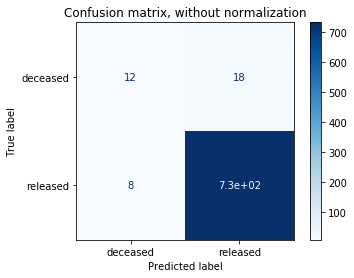

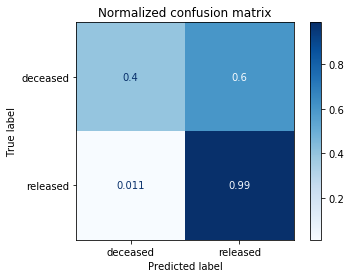

In [23]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfc, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

# <span style="color:orange">4:</span> Interpretation

The model will be interpreted in two ways:

1. What features are the most important?
2. How does the values of each feature affect the risk of death? 

## <span style="color:orange">4.1:</span> Feature importance

First, the model will be investigated by a simple feature importance using the RFC's impurity measure [7]. 

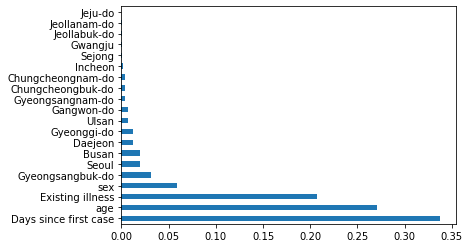

In [24]:
# Plot feature importance
feature_importance = pd.Series(rfc.feature_importances_, index=X.columns)
feature_importance.nlargest(21).plot(kind='barh')
plt.show()

Here it becomes evident that the days since first case is, in fact, a big predictor for whether someone will die or survive from the virus. Age and existing illness are also decent predictors, while regions and sex does not seem very good. The feature importance is the 'impurity feature importance' as described earlier. 

## <span style="color:orange">4.2:</span> Prediction investigations

Now, investigations as to how a deceased vs. a released person is predicted will be done using ELI5 [8].

In [25]:
# Find deceased correct predictions
predictions = rfc.predict(X_test)

deceasedCorrect = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
i = 0
for n in range(0, len(y_test)):
    if (predictions[n] == 'deceased') & (y_test.iloc[n,0] == 'deceased'):
        deceasedCorrect[i] = n
        i += 1
        
# Find deceased wrong predictions
deceasedWrong = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
i = 0
for n in range(0, len(y_test)):
    if (predictions[n] == 'deceased') & (y_test.iloc[n,0] == 'released'):
        deceasedWrong[i] = n
        i += 1
        if i == 12:
            break

Here, two plots showing deceased correct predictions will be shown. 

In [26]:
# deceasedCorrect 
i = deceasedCorrect[3]
print('Actual Label:', y_test.iloc[i,0])
show_prediction(rfc, X_test.iloc[[i]], show_feature_values=True, feature_names = X.columns.to_numpy())

Actual Label: deceased


In [27]:
# deceasedCorrect 
i = deceasedCorrect[4]
print('Actual Label:', y_test.iloc[i,0])
show_prediction(rfc, X_test.iloc[[i]], show_feature_values=True, feature_names = X.columns.to_numpy())

Actual Label: deceased


From the two predictions it can be seen that both existing illness and age are big predicters. But also that days since first case and sex have some say.

Below, wrong predictions and 'released' predictions will be shown.

In [28]:
# deceasedWrong
i = deceasedWrong[1]
print('Actual Label:', y_test.iloc[i,0])
show_prediction(rfc, X_test.iloc[[i]], show_feature_values=True, feature_names = X.columns.to_numpy())

Actual Label: released


Here is a good example of where the predictions fail. And old female person surviving the virus. This is a good example of why such limited features are not enough. 

Below a correct 'released' prediction shows the heavy bias in the model. When no values reach a certain point, the model is simply biased to predict 'released'. 

In [29]:
# deceasedWrong
i = 2
print('Actual Label:', y_test.iloc[i,0])
show_prediction(rfc, X_test.iloc[[i]], show_feature_values=True, feature_names = X.columns.to_numpy())

Actual Label: released


## <span style="color:orange">4.3:</span> Partial dependence plots

Here, how each feature affects the predictions will be investigated. The regions will not be investigated as previous results has not found anything particular interesting within them, and as they are OneHotEncoded categorical variables the plot would not provide much information.

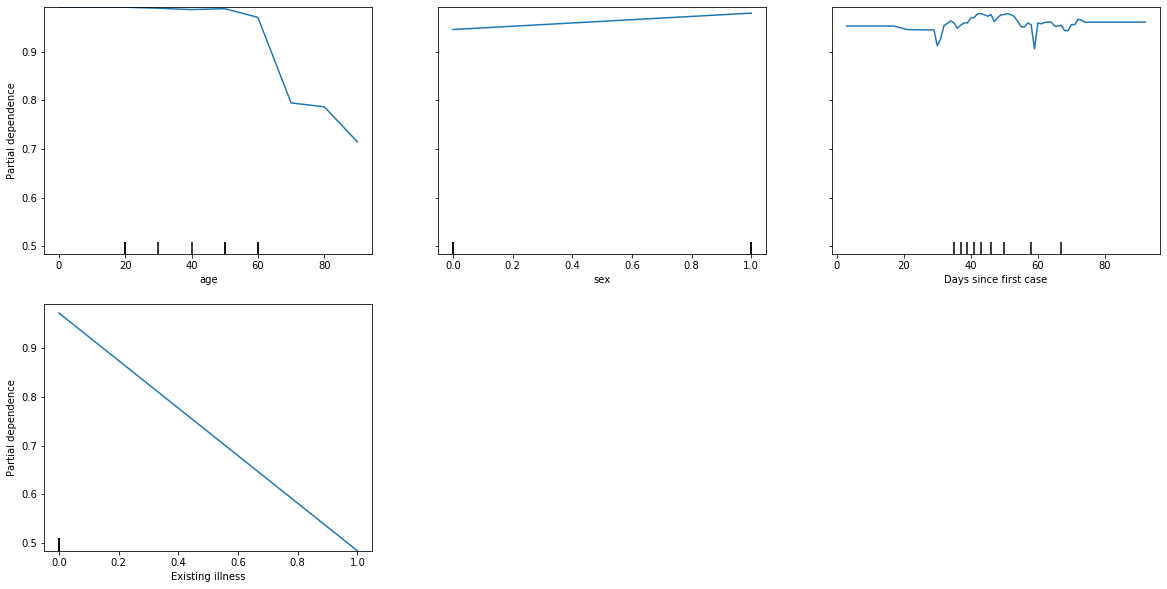

In [30]:
# Partial dependence plots
features = ['age', 'sex', 'Days since first case', 'Existing illness']
plot_partial_dependence(rfc, X_train, features, n_jobs=3)
fig = plt.gcf().set_size_inches(20, 10)

The plots shows probability of 'released' on the y-axis, meaning a lower value is increased risk of 'deceased'. 

From this brief overview, the model has found that:

1. As age reaches 50, risk of death starts significantly increasing
1. Male are slightly more prone to death than female
1. Having an existing illness significantly increase risk of 'deceased'
1. Days since first case is harder to read, but there does seem to be a slight rise in the middle.

However, the model should not be taken as ground truth as it is prone to bias.

# <span style="color:orange">5:</span> Beautiful graphs and widgetting

Here the beautiful graphs and widgets for the storyline will be constructed. The following plots will be made:

1. A confusion matrix showing how good the model performs
1. A bar chart showing feature importance of best model
2. A drop-down menu where the user can select each feature and see a ppd. graph of that feature
3. A widget where the user can put in their own numbers and get a prediction + explanation + recommendation

The plots will be made using Plotly and Ipywidgets [9] [10].

First, the confusion plot will be constructed using plotly with custom colors to replicate the look from sklearn. The plot will be normalized but show actual numbers on hovering and is inspired by [11].

In [31]:
# Get data
y_pred = rfc.predict(X_test)
cmNorm = confusion_matrix(y_test, y_pred, normalize='true').round(2)
cmRaw = confusion_matrix(y_test, y_pred, normalize=None)

# Invert it manually to fit heatmap
cmNorm = [[0.01, 0.99],
          [0.4, 0.6]]

cmRaw = [[12, 18],
         [8, 733]]

In [50]:
# Set labels
x = ['Deceased', 'Released']
y =  ['Released', 'Deceased']

# Custom colorscale to match Sklearn
colorscale = [[0, 'rgb(247, 251, 255)'], [0.5, 'rgb(102, 171, 212)'], [1, 'rgb(8,49,107)']]

# Set hovertext of actual numbers 
hover = [["Actual: 6", "Actual: 547"],
         ["Actual: 10", "Actual: 16"]]

# set up figure 
fig = ff.create_annotated_heatmap(cmNorm, x=x, y=y, text = hover, hoverinfo='text', colorscale=colorscale)

# add title
fig.update_layout(title_text="How well did the model performe on unseen data?")

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=20),
                        x=0.5,
                        y=-0.1,
                        showarrow=False,
                        text="What the model predicted",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=20),
                        x=-0.2,
                        y=0.5,
                        showarrow=False,
                        text="What the patient actually was",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200), width=900, height=700)
fig.update_xaxes(side="bottom")

# add colorbar
fig['data'][0]['showscale'] = True
fig

Secondly, the bar charts of the feature importances will be constructed using plotly. The bar-chart will not contain much interactivity except for the possibility to get some extra information when hovering over each bar. Here potential biases from some of the variables is highlighted, for instace, "Days since first case" and "Regions" are potentially prone to bias. Age and existing illness are known good predictors as they have been confirmed scientifically.

In [44]:
# Extract feature importances for plotting
featureNames = feature_importance.index.tolist()
featureImportance = np.multiply(feature_importance.tolist(),100)

# Group regions
regionImportance = sum(featureImportance[4:-1])
featureImportance = featureImportance[0:4]
featureImportance = np.append(featureImportance,regionImportance)
featureNames = featureNames[0:4]
featureNames.append('Regions')
featureNames[0] = 'Sex'
featureNames[1] = 'Age'

In [59]:
# Construct plotly barchart
fig = go.FigureWidget()
fig.layout.title = "Relative importance when predicting chance of survival of COVID-19 patients"
fig.add_bar(x=featureNames, y=featureImportance, text = ['Potentially biased', 'Good predicter', 'Potentially biased', 'Good predicter', 'Potentially biased'])
fig.update_layout(xaxis={'categoryorder':'total descending'}, width=900, height=700)
fig

FigureWidget({
    'data': [{'text': [Potentially biased, Good predicter, Potentially biased,
                …

Then, an interactive dropdown chart will be constructed, such that the reader can choose which feature from the graph above to investigate. Regions will not be shown as investigations show that these does not really shown anything of interest. The plot is inspired by [12].

In [35]:
# Get partial dependence graph data

# Sex
sex_y, sex_x = partial_dependence(rfc, X_train, [0])
sex_y = np.multiply(sex_y[0],100)
sex_x = ['Male', 'Female']

# Age
age_y, age_x = partial_dependence(rfc, X_train, [1])
age_y = np.multiply(age_y[0],100)
age_x = age_x[0]

# Days since first case
dsfc_y, dsfc_x = partial_dependence(rfc, X_train, [2])
dsfc_y = np.multiply(dsfc_y[0],100)
dsfc_x = dsfc_x[0]

# Existing illness
ei_y, ei_x = partial_dependence(rfc, X_train, [3])
ei_y = np.multiply(ei_y[0],100)
ei_x = ['No existing illness', 'Existing illness present']

In [58]:
# Make interactive PDP plots

# Show first line
initLine = go.Scatter(x=dsfc_x, y=dsfc_y)

# Construct dropdown menu and graph-changes
updatemenus = [
    {
        'buttons': [
            {
                'method': 'restyle',
                'label': 'Days since first case',
                'args': [
                    {'x': [dsfc_x], 'y': [dsfc_y], 'xaxis': "test"},
                ]
            },
            {
                'method': 'restyle',
                'label': 'Age',
                'args': [
                    {'x': [age_x], 'y': [age_y], 'xaxis': "nooo"},
                ]
            },
            {
                'method': 'restyle',
                'label': 'Existing illness',
                'args': [
                    {'x': [ei_x], 'y': [ei_y]},
                ]
            },
            {
                'method': 'restyle',
                'label': 'Sex',
                'args': [
                    {'x': [sex_x], 'y': [sex_y]},
                ]
            }
        ],
        'direction': 'down',
        'showactive': True,
    }
]

# Update layout based on dropdown
layout = go.Layout(
    title_text = "How each feature impacts a prediction",
    yaxis_title="Chance of survival in %",
    xaxis_title="Value according to dropdown selected",
    width=900, 
    height=500,
    updatemenus=updatemenus,
)

# Plot figure
figure = go.Figure(data=[initLine], layout=layout)
figure

The graphs are identical to the previous PDP plots, however, investigating "Days since first case" now shows more granularity, and an interesting pattern emerges, showing lower chance of fatality in the beginning, then a steep drop followed by a rise and a new drop and a slight rise again. No conclusions can be made, but many hypothesis could; For instance, a slightly higher chance of death in the beginning is the disease was not very known, then less chance in the middle as awareness increased dramatically and then slight increase but a higher base level in the end as it reaches elderly in society and awareness relaxing slightly. 

Finally, the risk-profiling widget will be constructed. First, the user will be given a task of inputting his/her own values in the tabs below. This part is inspired by [13].

In [60]:
# Specify sex picker
sexPick = widgets.RadioButtons(options=['Male','Female'],value='Male',layout={'width': 'max-content'})
# Specificy age picker
agePick = widgets.Dropdown(options=[('0', 0), ('10', 10), ('20', 20), 
                                    ('30',30), ('40',40), ('50',50), 
                                    ('60',60),('70',70),('80', 80),('90',90)],
                                    value=20,
                                    layout={'width': 'max-content'},
                                    description='Pick closest:',)
# Specify existing illness picker
eiPick = widgets.RadioButtons(options=['Yes','No'],value = 'No', layout={'width': 'max-content'})

# Specify 'Days since first case' picker
dsfcPick = widgets.IntRangeSlider(value=[20, 40],
                                       min=0,
                                       max=73,
                                       step=1,
                                       description='Approx:',
                                       disabled=False,
                                       continuous_update=False,
                                       orientation='horizontal',
                                       readout=True,
                                       readout_format='d',)

# Specify regions picker
regPick = widgets.Dropdown(options=['Busan','Chungcheongbuk-do','Chungcheongnam-do',
                                    'Daejeon','Gangwon-do','Gwangju','Gyeonggi-do',
                                    'Gyeongsangbuk-do','Gyeongsangnam-do','Incheon',
                                    'Jeju-do','Jeollabuk-do','Jeollanam-do','Sejong','Seoul',
                                    'Ulsan'],
                                    value='Busan',
                                    description='Pick:',
                                    disabled=False,)

# Build tabs
accordion = widgets.Accordion(children=[sexPick,agePick,eiPick,dsfcPick,regPick])
accordion.set_title(0, 'Sex')
accordion.set_title(1, 'Age')
accordion.set_title(2, 'Existing illness')
accordion.set_title(3, 'Days since first case')
accordion.set_title(4, 'Region')
accordion

Accordion(children=(RadioButtons(layout=Layout(width='max-content'), options=('Male', 'Female'), value='Male')…

Then, the values will be given to the RandomForestClassifier and predictions will be made.

In [61]:
# Function takes input from widgets and returns person information to be used for prediction
def personalInfo(sex, age, ei, dsfc, reg):

    # Get average dsfc
    dsfc = sum(dsfc)/2
    
    # Set all regions to 0
    busan = 0
    Chungcheongbuk_do = 0
    Chungcheongnam_do = 0
    Daejeon = 0
    Gangwon_do = 0
    Gwangju = 0
    Gyeonggi_do = 0
    Gyeongsangbuk_do = 0
    Gyeongsangnam_do = 0
    Incheon = 0
    Jeju_do = 0
    Jeollabuk_do = 0
    Jeollanam_do = 0
    Sejong = 0
    Seoul = 0
    Ulsan = 0
    
    # Set sex
    if sex == 'Male':
        sex = 0
    else:
        sex = 1
        
    # Set existing illes
    if ei == "Yes":
        ei = 1
    else:
        ei = 0   
    
    # Set region 
    if reg == "Busan":
        busan = 1
    elif reg == "Chungcheongbuk-do":
        Chungcheongbuk_do = 1
    elif reg == "Chungcheongnam-do":
        Chungcheongnam_do = 1
    elif reg == "Daejeon":
        Daejeon = 1
    elif reg == "Gangwon-do":
        Gangwon_do = 1
    elif reg == "Gwangju":
        Gwangju = 1
    elif reg == "Gyeonggi-do":
        Gyeonggi_do = 1
    elif reg == "Gyeongsangbuk-do":
        Gyeongsangbuk_do = 1
    elif reg == "Gyeongsangnam-do":
        Gyeongsangnam_do = 1
    elif reg == "Incheon":
        Incheon = 1
    elif reg == "Jeju-do":
        Jeju_do = 1
    elif reg == "Jeollabuk-do":
        Jeollabuk_do = 1
    elif reg == "Jeollanam-do":
        Jeollanam_do = 1
    elif reg == "Sejong":
        Sejong = 1
    elif reg == "Seoul":
        Seoul = 1
    elif reg == "Ulsan":
        Ulsan = 1
    
    # Construct dataframe for prediction
    X_pred = pd.DataFrame({"sex":[sex], 
                            "age":[age],  
                            "Days since first case":[dsfc],
                            "Existing illness":[ei],
                            "Busan":[busan],
                            "Chungcheongbuk-do":[Chungcheongbuk_do],
                            "Chungcheongnam-do":[Chungcheongnam_do],
                            "Daejeon":[Daejeon],
                            "Gangwon-do":[Gangwon_do],
                            "Gwangju":[Gwangju],
                            "Gyeonggi-do":[Gyeonggi_do],
                            "Gyeongsangbuk-do":[Gyeongsangbuk_do],
                            "Gyeongsangnam-do":[Gyeongsangnam_do],
                            "Incheon":[Incheon],
                            "Jeju-do":[Jeju_do],
                            "Jeollabuk-do":[Jeollabuk_do],
                            "Jeollanam-do":[Jeollanam_do],
                            "Sejong":[Sejong],
                            "Seoul":[Seoul],
                            "Ulsan":[Ulsan]})
    return X_pred

In [62]:
# Function takes a profile for prediction and returns a risk profile
# - HIGH
# - MEDIUM
# - LOW
def riskProfile(personal_info):
    
    # Predict using model
    prediction = rfc.predict_proba(personal_info)
    
    if prediction[0][1] <= 0.5:
        # High risk
        x = "High risk"
    elif (prediction[0][1] > 0.5) & (prediction[0][1] <= 0.8):
        x = "Medium risk"
    else:
        x = "Low risk"
        
    return x

And finally a button takes the input from the user, and when the user clicks it returns the risk-profile.

In [1]:
# Construct button with images

highrisk = Image(filename='images/highrisk.png',width=700)
mediumrisk = Image(filename='images/mediumrisk.png',width=700)
lowrisk = Image(filename='images/lowrisk.png',width=700)

btn = widgets.Button(description='Get risk-profile')
out = widgets.Output(layout={'border': '0px solid black'})
display(btn)

def btn_eventhandler(obj):
    out.clear_output()
    info = personalInfo(sexPick.value, agePick.value, eiPick.value, dsfcPick.value, regPick.value)
    prof = riskProfile(info)
    with out:
        if prof == "High risk":
            display(highrisk)
        elif prof == "Medium risk":
            display(mediumrisk)
        else:
            display(lowrisk)

btn.on_click(btn_eventhandler)
out

# Construct button with risk predictions

btn2 = widgets.Button(description='Get prediction info')
out = widgets.Output(layout={'border': '0px solid black'})
display(btn2)

def btn_eventhandler(obj):
    out.clear_output()
    info = personalInfo(sexPick.value, agePick.value, eiPick.value, dsfcPick.value, regPick.value)
    with out:
        print("This table shows the prediction y = 'prediction' together with the probability of survival.")
        print("The contribution indicates how much 'Feature' with 'Value' contributed to the prediction.")
        print("Existing illness present = 1. Sex female = 1. Region = 1 means person is from that region.")
        print("If no features specifically lowers chance of survival, the model will have a high <BIAS> towards saying 'Released'.")
        display(show_prediction(rfc, info, show_feature_values=True, feature_names = info.columns.to_numpy()))

btn2.on_click(btn_eventhandler)
out

NameError: name 'Image' is not defined

The risk profile is based on some information from the official South Korean KCDC, however, the profiles are made only for show as an MVP. The idea behind the profile is that, given citizens have an app, personalizing risk profiles could increase compliance and spread awareness quicker among tech-users. However, privacy issues and the potential that people getting a "high-risk" profile directly presented should be considered before deploying something like this.

The actually prediction info is here included mainly to let the user play around with the model and see how different inputs affect the output. This part is not mend as being something that would necesarily be provided to the general public.

# <span style="color:orange">6:</span> Conclusion and discussion

There are multiple points which could be discussed here, but it will be kept brief.

## <span style="color:orange">6.1:</span> Discussion

For the dataset used, it must be noted that it is highly imbalanced and highly prone to bias. Additionally, the dataset used is very new which means that; 1. It is prone to errors (as discovered) and 2. It may include skewed distributions due to recency - for instance, are there more female attracting COVID-19, or is it just that right now more data for female has been entered into the dataset by chance. 

The dataset is far from perfect and would genererally not be advised for machinelearning, however, this part shows that some interesting insights can still be extracted, although these were already known. The machine learning used here is not very sophisticated and only one type of model (RandomForestClassifier) was tried, however, due to the limitations of the dataset it was argued that time would not be well spend going too much into detail with the ML.  

## <span style="color:orange">6.2:</span> Concluding remarks

In conclusion, it is shown that ML can be used to drive an interpretable analysis gaining insights into a spreading pandemic, and that it can be used to create user-interactive modules that can be used to create a storyline with multiple purposes in 1: Educating the reader about COVID-19, 2: Educating the reader about ML and 3: Showing an MVP of how governments could use ML in battling global pandemics.

The story-elements have not been brought to live through vivid descriptions and story-telling. This is done only on the website. 

The main learnings specifically was that old 'Age' and presence of 'Existing illness' significantly increases risk of death from COVID-19. Additionally, the 'sex' male seems more prone to suffering fatal attacks. Finally, 'Days since first case' seems to have some say in whether the attack will be fatal or not- perhabs reflecting preparedness of society. 

# <span style="color:orange">7:</span> References
1. https://github.com/ResidentMario/missingno
1. https://sci2s.ugr.es/imbalanced#Evaluation%20in%20imbalanced%20domains
1. https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
1. https://scikit-learn.org/stable/
1. https://stats.stackexchange.com/questions/264533/how-should-feature-selection-and-hyperparameter-optimization-be-ordered-in-the-m
1. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
1. https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
1. https://eli5.readthedocs.io/en/latest/overview.html
1. https://plotly.com/python/
1. https://ipywidgets.readthedocs.io/en/latest/
1. https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap
1. https://www.kaggle.com/jrmistry/plotly-how-to-change-plot-data-using-dropdowns
1. https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
